In [51]:
# !pip install -r requirements.txt
# Python 3.9.0 and libraries in the requirements.txt has been used in this project.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import os
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples, r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
#from scikeras.wrappers import KerasRegressor
from keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from keras.optimizers import Adam, SGD
#from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = 'CarPrice_Assignment.csv'
data = pd.read_csv(file_path)

In [4]:
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Analyzing only numerical features 

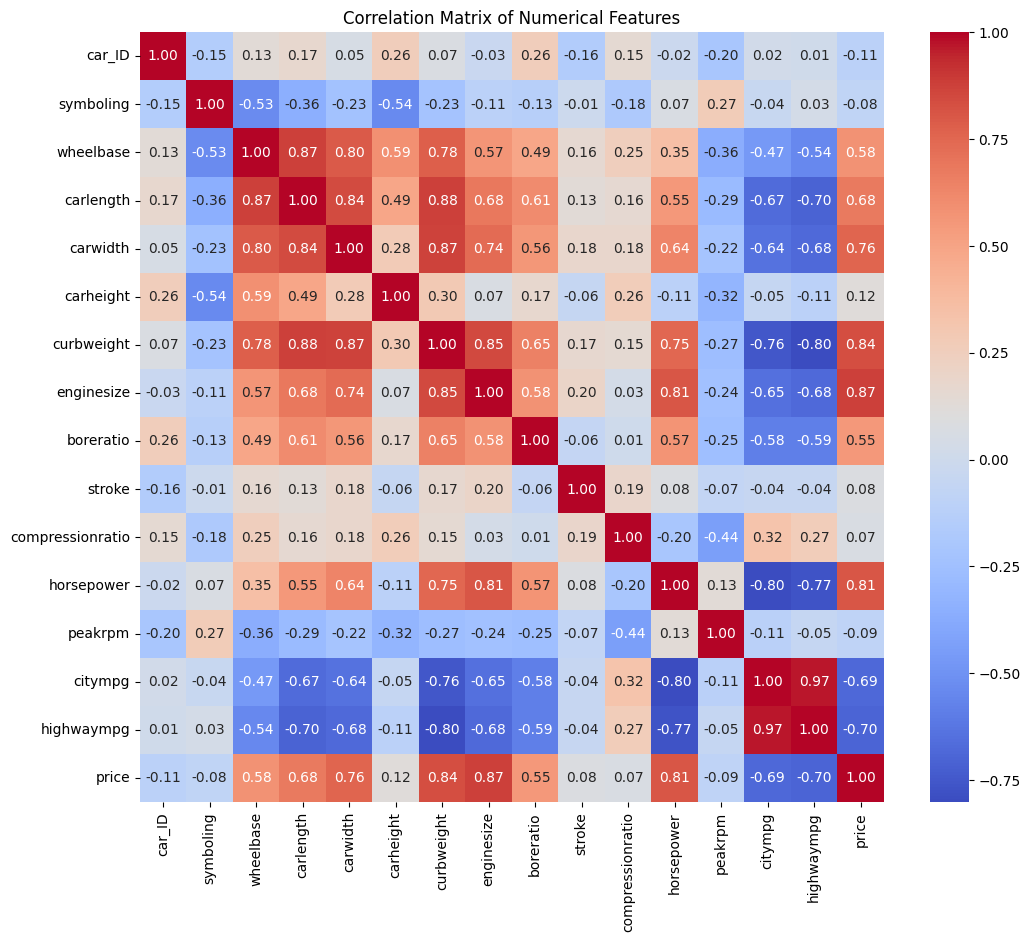

In [5]:
numerical_cols_only = data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_cols_only.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Correlation Matrix to Investigate which features have an effect on price.

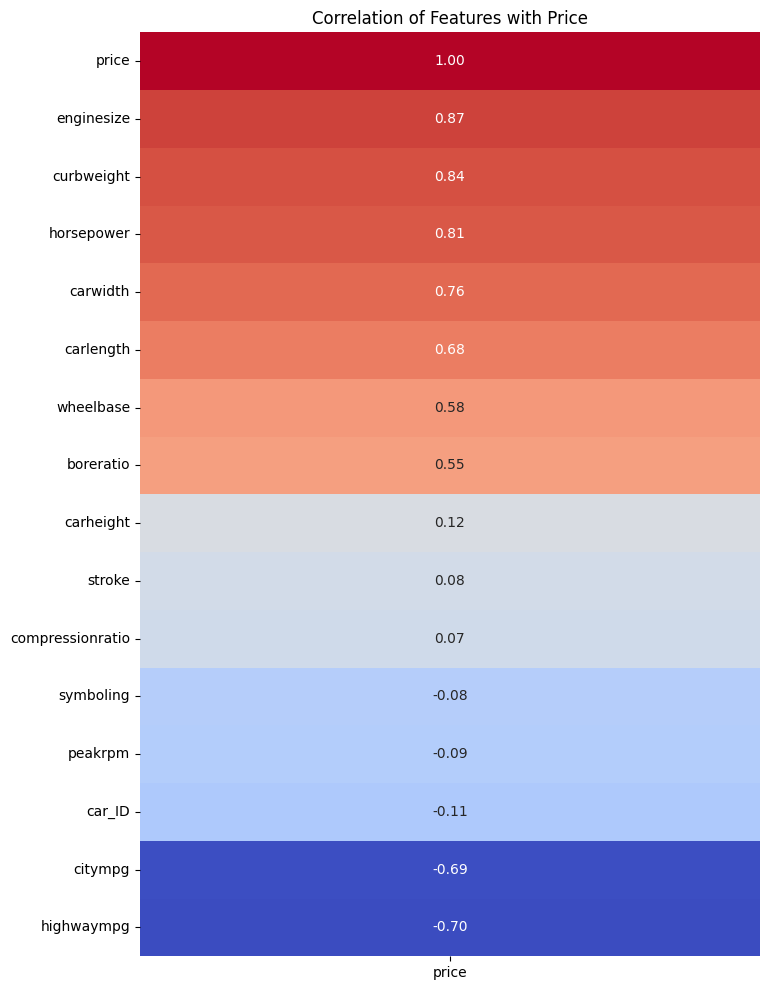

In [6]:
correlations_fixed = numerical_cols_only.corr()['price'].sort_values(ascending=False)

plt.figure(figsize=(8, 12))
sns.heatmap(correlations_fixed.to_frame(), annot=True, cmap='coolwarm', cbar=False, fmt='.2f')
plt.title('Correlation of Features with Price')
plt.show()

# Removal of features that has a correlation smaller than 0.12

In [7]:
low_correlation_threshold = 0.12
low_correlation_features = correlations_fixed[abs(correlations_fixed) < low_correlation_threshold].index.tolist()

low_correlation_features

['carheight', 'stroke', 'compressionratio', 'symboling', 'peakrpm', 'car_ID']

In [8]:
data_cleaned = data.drop(columns=low_correlation_features)

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CarName         205 non-null    object 
 1   fueltype        205 non-null    object 
 2   aspiration      205 non-null    object 
 3   doornumber      205 non-null    object 
 4   carbody         205 non-null    object 
 5   drivewheel      205 non-null    object 
 6   enginelocation  205 non-null    object 
 7   wheelbase       205 non-null    float64
 8   carlength       205 non-null    float64
 9   carwidth        205 non-null    float64
 10  curbweight      205 non-null    int64  
 11  enginetype      205 non-null    object 
 12  cylindernumber  205 non-null    object 
 13  enginesize      205 non-null    int64  
 14  fuelsystem      205 non-null    object 
 15  boreratio       205 non-null    float64
 16  horsepower      205 non-null    int64  
 17  citympg         205 non-null    int

# Here transformed categorical data to numerical data so that we can make comments on them about their effects on price.

# At first, one-hot encoding has been applied and our dataset was having 186 features with this encoding. This is so much and unnecessary.

# Instead of going with one-hot encoder, Label Encoder has been applied.

## IN TOTAL, one-hot encoder makes 186 columns but label encoder makes only 19 columns

In [9]:
data_encoded_alt = data_cleaned.copy()


binary_mappings = {
    'doornumber': {'two': 0, 'four': 1},  # map 'two' to 0 and 'four' to 1
    'fueltype': {'gas': 0, 'diesel': 1},  # Map 'gas' to 0 and 'diesel' to 1
    'aspiration': {'std': 0, 'turbo': 1},  # Map 'std' to 0 and 'turbo' to 1
    'enginelocation': {'front': 0, 'rear': 1}  # Map 'front' to 0 and 'rear' to 1
}

for col, mapping in binary_mappings.items():
    data_encoded_alt[col] = data_encoded_alt[col].map(mapping)

label_encoder = LabelEncoder()
multiclass_columns = ['carbody', 'drivewheel', 'enginetype', 'cylindernumber', 'fuelsystem']
for col in multiclass_columns:
    data_encoded_alt[col] = label_encoder.fit_transform(data_encoded_alt[col])

data_encoded_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CarName         205 non-null    object 
 1   fueltype        205 non-null    int64  
 2   aspiration      205 non-null    int64  
 3   doornumber      205 non-null    int64  
 4   carbody         205 non-null    int32  
 5   drivewheel      205 non-null    int32  
 6   enginelocation  205 non-null    int64  
 7   wheelbase       205 non-null    float64
 8   carlength       205 non-null    float64
 9   carwidth        205 non-null    float64
 10  curbweight      205 non-null    int64  
 11  enginetype      205 non-null    int32  
 12  cylindernumber  205 non-null    int32  
 13  enginesize      205 non-null    int64  
 14  fuelsystem      205 non-null    int32  
 15  boreratio       205 non-null    float64
 16  horsepower      205 non-null    int64  
 17  citympg         205 non-null    int

# Label encoded version of our data is ready. Just car name is left. We can remove the car name data if we want or we can just take manufacturer name and apply label encoding again. We will just looking for brand name, not model name. So we will see that "Audi" or "Alfa-Romero" name has an effect on price or not.

# Brand names had typos. toyota toyouta. vw vokswagen volkswagen. I corrected these type of typos and with that I looked for correlation.

In [10]:
data_encoded_alt['CarMake'] = data_encoded_alt['CarName'].str.split(' ').str[0].str.lower()
data_encoded_alt = data_encoded_alt.drop(columns=['CarName'])
data_encoded_alt['CarMake'] = label_encoder.fit_transform(data_encoded_alt['CarMake'])
unique_carmakes = data['CarName'].str.split(' ').str[0].str.lower().unique()

unique_carmakes

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

# Buick Porsche Jaguar BMW affects on price in a positive way while Toyota Honda Subaru affects in negative way. There are luxury brands and budget brands for sure BUT Buick is not that luxury brand? Also Audi & BMW should be similar but they are not. 

# We think that this dataset is biased towards Buick, regarding prices. Samples are not normal distributed. Thus we removed this feature. 

In [11]:
corrections = {
    'maxda': 'mazda',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen'
}
data_reverted = data_encoded_alt.copy()

data_reverted['CarMake'] = data['CarName'].str.split(' ').str[0].str.lower().replace(corrections)

data_corrected = pd.get_dummies(data_reverted, columns=['CarMake'], drop_first=True)

carmake_columns_corrected = [col for col in data_corrected.columns if col.startswith('CarMake_')]
carmake_price_correlation_corrected = data_corrected[carmake_columns_corrected + ['price']].corr()['price'].sort_values(ascending=False)

carmake_price_correlation_corrected

price                 1.000000
CarMake_buick         0.515094
CarMake_porsche       0.359581
CarMake_jaguar        0.326074
CarMake_bmw           0.324731
CarMake_volvo         0.143017
CarMake_audi          0.108117
CarMake_peugeot       0.066105
CarMake_saab          0.042414
CarMake_mercury       0.028344
CarMake_renault      -0.045856
CarMake_isuzu        -0.077182
CarMake_mazda        -0.099005
CarMake_volkswagen   -0.100100
CarMake_chevrolet    -0.111168
CarMake_nissan       -0.111383
CarMake_plymouth     -0.125359
CarMake_mitsubishi   -0.131811
CarMake_dodge        -0.145233
CarMake_subaru       -0.148167
CarMake_honda        -0.166260
CarMake_toyota       -0.182997
Name: price, dtype: float64

## Removal of Car Name from training dataset

In [12]:
datatocormatrix = data_encoded_alt.drop(columns=['CarMake'])

## Looking for the correlation once again, but this time categorical features are included as well. 

In [13]:
datatocormatrix.corr()['price'].sort_values(ascending=False)

price             1.000000
enginesize        0.874145
curbweight        0.835305
horsepower        0.808139
carwidth          0.759325
carlength         0.682920
drivewheel        0.577992
wheelbase         0.577816
boreratio         0.553173
fuelsystem        0.526823
enginelocation    0.324973
aspiration        0.177926
fueltype          0.105679
enginetype        0.049171
doornumber        0.031835
cylindernumber   -0.027628
carbody          -0.083976
citympg          -0.685751
highwaympg       -0.697599
Name: price, dtype: float64

## Cleanest data which is our final training data is ready.

In [14]:
cleanest_data = datatocormatrix.drop(columns=['fueltype', 'enginetype', 'doornumber', 'cylindernumber', 'carbody'])

## Multicollinearity phenomena can be directly seen from this correlation heatmap. Our goal is to reflect affects of Lasso, Ridge, and Tree based models to multicollinearity. 

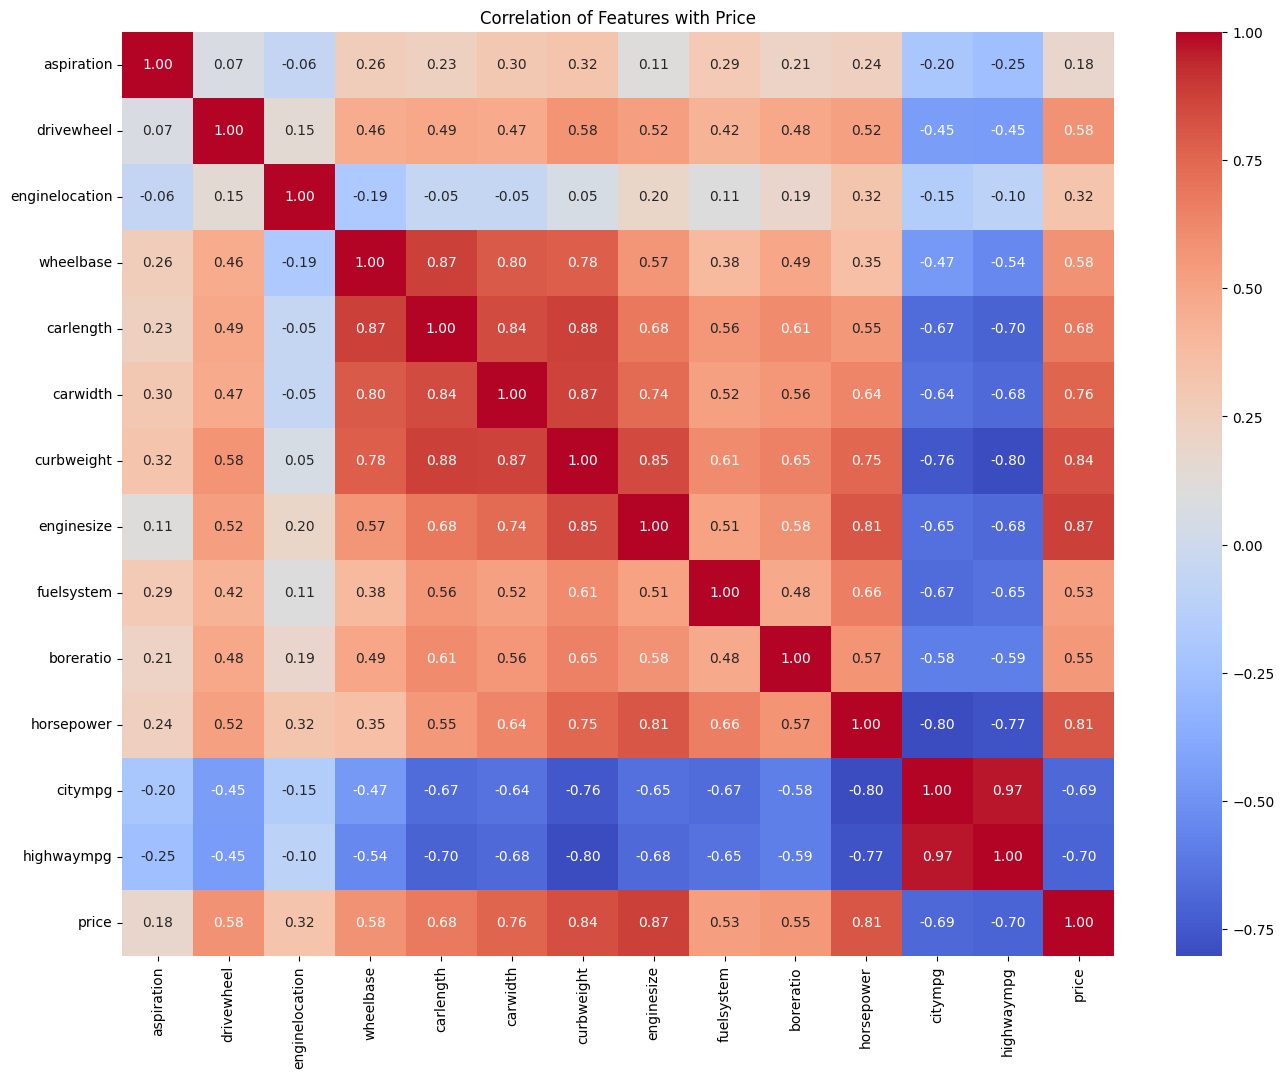

In [15]:
plt.figure(figsize=(16, 12))

price_correlation = cleanest_data.corr()#[['price']].sort_values(by='price', ascending=False)
sns.heatmap(price_correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title("Correlation of Features with Price")
plt.show()


# Model Training & Evaluation

#### Train/Test Data Split and Log Transformation

In [16]:
X = cleanest_data.drop(columns=['price'])
y = cleanest_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_log = np.log(y_train+1)
y_test_log= np.log(y_test+1)

## Linear Regression

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train_updated = mean_squared_error(y_train, y_pred_train)
mse_test_updated = mean_squared_error(y_test, y_pred_test)
r2_train_updated = r2_score(y_train, y_pred_train)
r2_test_updated = r2_score(y_test, y_pred_test)

mse_train_updated, mse_test_updated, r2_train_updated, r2_test_updated
print("r2 Score of Train Data: ", r2_train_updated)
print("r2 Score of Test Data: ", r2_test_updated)
print("MSE - Training:", mse_train_updated)
print("MSE - Testing:", mse_test_updated)

r2 Score of Train Data:  0.877229976692173
r2 Score of Test Data:  0.8146175098822105
MSE - Training: 7321738.685908276
MSE - Testing: 14634839.17058171


## Linear Regression for log transformated data

In [18]:
model_updated = LinearRegression()
model_updated.fit(X_train, y_train_log)

y_pred_train = model_updated.predict(X_train)
y_pred_test = model_updated.predict(X_test)

r2_train_updated = r2_score(y_train_log, y_pred_train)
r2_test_updated = r2_score(y_test_log, y_pred_test)

print("r2 Score of Train Data: ", r2_train_updated)
print("r2 Score of Test Data: ", r2_test_updated)

r2 Score of Train Data:  0.8909431064329951
r2 Score of Test Data:  0.8760847910606996


## Inverse Transformation of y is needed to calculate MSE correctly. 

In [19]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)


MSE - Training (Original Scale): 6319287.83261753
MSE - Testing (Original Scale): 13113161.051069349


## Lasso and Ridge

In [20]:
from sklearn.linear_model import Ridge, Lasso

In [21]:
model=Lasso()
model.fit(X_train,y_train_log)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Lasso Regression model:")
print("r2 Score of Train Data: ",model.score(X_train, y_train_log))
print("r2 Score of Test Data: ",model.score(X_test, y_test_log))

Lasso Regression model:
r2 Score of Train Data:  0.8334065504302852
r2 Score of Test Data:  0.8961144013764512


In [22]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)

MSE - Training (Original Scale): 14467819.654161628
MSE - Testing (Original Scale): 11785870.121293524


## Grid Search for Hyperparameter Tuning of Lasso

In [23]:
kcv_index = KFold(n_splits=3, shuffle=True, random_state=1773)
lasso_pipe = make_pipeline(Lasso()) 

param_grid = {'lasso__alpha' : np.linspace(0.0001,0.5,100)} 

gs_lasso = GridSearchCV(estimator = lasso_pipe, param_grid = param_grid, scoring='r2', cv=kcv_index, return_train_score=True) 
gs_lasso.fit(X_train, y_train_log)

GridSearchCV(cv=KFold(n_splits=3, random_state=1773, shuffle=True),
             estimator=Pipeline(steps=[('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.00000000e-04, 5.14949495e-03, 1.01989899e-02, 1.52484848e-02,
       2.02979798e-02, 2.53474747e-02, 3.03969697e-02, 3.54464646e-02,
       4.04959596e-02, 4.55454545e-02, 5.05949495e-02, 5.56444444e-02,
       6.06939394e-02, 6.57434343...
       3.83861616e-01, 3.88911111e-01, 3.93960606e-01, 3.99010101e-01,
       4.04059596e-01, 4.09109091e-01, 4.14158586e-01, 4.19208081e-01,
       4.24257576e-01, 4.29307071e-01, 4.34356566e-01, 4.39406061e-01,
       4.44455556e-01, 4.49505051e-01, 4.54554545e-01, 4.59604040e-01,
       4.64653535e-01, 4.69703030e-01, 4.74752525e-01, 4.79802020e-01,
       4.84851515e-01, 4.89901010e-01, 4.94950505e-01, 5.00000000e-01])},
             return_train_score=True, scoring='r2')

In [24]:
y_pred_train = gs_lasso.predict(X_train)
y_pred_test = gs_lasso.predict(X_test)

print("Hyperparameter Tunning of Lasso Regression models:")
print("r2 Score of Train Data: ", gs_lasso.score(X_train, y_train_log))
print("r2 Score of Test Data: ", gs_lasso.score(X_test, y_test_log))

Hyperparameter Tunning of Lasso Regression models:
r2 Score of Train Data:  0.8909369241265298
r2 Score of Test Data:  0.8762583404842322


In [25]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)


MSE - Training (Original Scale): 6329064.3476096885
MSE - Testing (Original Scale): 13091974.9918317


## Ridge

In [26]:
ridge = Ridge()
ridge.fit(X_train,y_train_log)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

print("Ridge Regression models:")
print("r2 Score of Train Data: ",model.score( X_train, y_train_log))
print("r2 Score of Test Data: ",model.score( X_test, y_test_log))

Ridge Regression models:
r2 Score of Train Data:  0.8334065504302852
r2 Score of Test Data:  0.8961144013764512


In [27]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)


MSE - Training (Original Scale): 7112793.878648807
MSE - Testing (Original Scale): 12349494.558752082


## Grid Search for Hyperparameter Tuning of Ridge

In [28]:
ridge_pipe = make_pipeline(Ridge()) 

param_grid = {'ridge__alpha' : np.linspace(0.01, 5, 50)}
    
grid_search = GridSearchCV(estimator = ridge_pipe, param_grid = param_grid, scoring='r2', cv=kcv_index, return_train_score=True) 
grid_search.fit(X_train, y_train_log)

GridSearchCV(cv=KFold(n_splits=3, random_state=1773, shuffle=True),
             estimator=Pipeline(steps=[('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([0.01      , 0.11183673, 0.21367347, 0.3155102 , 0.41734694,
       0.51918367, 0.62102041, 0.72285714, 0.82469388, 0.92653061,
       1.02836735, 1.13020408, 1.23204082, 1.33387755, 1.43571429,
       1.53755102, 1.63938776, 1.74122449, 1.84306122, 1.9...
       2.04673469, 2.14857143, 2.25040816, 2.3522449 , 2.45408163,
       2.55591837, 2.6577551 , 2.75959184, 2.86142857, 2.96326531,
       3.06510204, 3.16693878, 3.26877551, 3.37061224, 3.47244898,
       3.57428571, 3.67612245, 3.77795918, 3.87979592, 3.98163265,
       4.08346939, 4.18530612, 4.28714286, 4.38897959, 4.49081633,
       4.59265306, 4.6944898 , 4.79632653, 4.89816327, 5.        ])},
             return_train_score=True, scoring='r2')

In [29]:
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

print("Hyperparameter Tunning of Ridge Regression models:")
print("r2 Score of Train Data: ",grid_search.score( X_train, y_train_log))
print("r2 Score of Test Data: ",grid_search.score( X_test, y_test_log))

Hyperparameter Tunning of Ridge Regression models:
r2 Score of Train Data:  0.8908665470993513
r2 Score of Test Data:  0.8766759857592599


In [30]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)

MSE - Training (Original Scale): 6359546.256246175
MSE - Testing (Original Scale): 12985302.918716183


## Decision Tree

In [31]:
d_tree = DecisionTreeRegressor(max_depth=4, random_state=1773)
d_tree.fit(X_train, y_train_log)

y_pred_train = d_tree.predict(X_train)
y_pred_test = d_tree.predict(X_test)

print("Decision Tree Regression")
print("r2 Score of Train Data: ",d_tree.score(X_train, y_train_log))
print("r2 Score of Test Data: ",d_tree.score(X_test, y_test_log))

Decision Tree Regression
r2 Score of Train Data:  0.9326458363056922
r2 Score of Test Data:  0.8722358546728481


In [32]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)

MSE - Training (Original Scale): 3226016.3481032965
MSE - Testing (Original Scale): 10301558.621295594


## Random Search for Hyperparameter Tuning of Decision Tree

In [33]:
tree = DecisionTreeRegressor(random_state=1773)

param_grid = {'max_depth': list(range(1, 9)),
              'max_leaf_nodes': [2, 3, 4, 5, 6, 7,None],
              'min_samples_split': list(range(2,8)),
               'min_samples_leaf': list(range(4, 8)),
              }

cv_index = KFold(n_splits=5, shuffle=True, random_state=1773) 

rd_search = RandomizedSearchCV(estimator = tree, 
                               param_distributions = param_grid, 
                               scoring='r2', 
                               cv = cv_index,
                               random_state=1773) 
rd_search.fit(X_train, y_train_log)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1773, shuffle=True),
                   estimator=DecisionTreeRegressor(random_state=1773),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7,
                                                           None],
                                        'min_samples_leaf': [4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6,
                                                              7]},
                   random_state=1773, scoring='r2')

In [34]:
y_pred_train = rd_search.predict(X_train)
y_pred_test = rd_search.predict(X_test)

print("Hyperparameter Tunning of Decision Tree Regression")
print("r2 Score of Train Data:  %.4f " % rd_search.score(X_train, y_train_log))
print("r2 Score of Test Data:  %.4f " % (rd_search.score(X_test, y_test_log)))

Hyperparameter Tunning of Decision Tree Regression
r2 Score of Train Data:  0.8982 
r2 Score of Test Data:  0.8744 


In [35]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)

MSE - Training (Original Scale): 5149248.144971598
MSE - Testing (Original Scale): 10902571.670690013


## Random Forest

### Random Forest without Log Transformation (Yield Better Results only for RF)

In [36]:
rf_reg= RandomForestRegressor(max_depth=4, random_state=1773)
rf_reg.fit(X_train, y_train)

y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

mse_train_updated = mean_squared_error(y_train, y_pred_train)
mse_test_updated = mean_squared_error(y_test, y_pred_test)

print("Random Forest Regression models:")
print("r2 Score of Train Data: ",rf_reg.score( X_train, y_train))
print("r2 Score of Train Data: ",rf_reg.score( X_test, y_test))
print("MSE - Training:", mse_train_updated)
print("MSE - Testing:", mse_test_updated)

Random Forest Regression models:
r2 Score of Train Data:  0.9519665725569841
r2 Score of Train Data:  0.9454493638485568
MSE - Training: 2864609.7349390658
MSE - Testing: 4306446.55933814


### RF with Log Transformation

In [37]:
rf_reg= RandomForestRegressor(max_depth=4, random_state=1773)
rf_reg.fit(X_train, y_train_log)

y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

print("Random Forest Regression models:")
print("r2 Score of Train Data: ",rf_reg.score( X_train, y_train_log))
print("r2 Score of Train Data: ",rf_reg.score( X_test, y_test_log))

Random Forest Regression models:
r2 Score of Train Data:  0.9486295936755412
r2 Score of Train Data:  0.9303792141988144


In [38]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)


MSE - Training (Original Scale): 2953516.440127428
MSE - Testing (Original Scale): 4587603.748345486


## Random Search for Hyperparameter Tuning of Random Forest

In [39]:
rf = RandomForestRegressor(random_state=1773) 

param_grid = {'max_depth': list(range(1, 9)),
              'max_leaf_nodes': [2, 3, 4, 5, 6, 7,None],
              'min_samples_split': list(range(2,8)),
               'min_samples_leaf': list(range(4, 8)),
              }

cv_index = KFold(n_splits=5, shuffle=True, random_state=1773) 

rd_search = RandomizedSearchCV(estimator = rf, 
                               param_distributions = param_grid,  
                               scoring='r2', 
                               cv = cv_index,
                               random_state=1773)
rd_search.fit(X_train.to_numpy(), y_train_log)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1773, shuffle=True),
                   estimator=RandomForestRegressor(random_state=1773),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7,
                                                           None],
                                        'min_samples_leaf': [4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6,
                                                              7]},
                   random_state=1773, scoring='r2')

In [40]:
y_pred_train = rd_search.predict(X_train)
y_pred_test = rd_search.predict(X_test)

mse_train_updated = mean_squared_error(y_train_log, y_pred_train)
mse_test_updated = mean_squared_error(y_test_log, y_pred_test)

print("Hyperparameter Tunning of Random Forest Regression models:")
print("r2 Score of Train Data:  %.4f "  % rd_search.score(X_train, y_train_log))
print("r2 Score of Test Data:  %.4f " % rd_search.score(X_test, y_test_log))
print("MSE - Training:", mse_train_updated)
print("MSE - Testing:", mse_test_updated)

Hyperparameter Tunning of Random Forest Regression models:
r2 Score of Train Data:  0.9182 
r2 Score of Test Data:  0.9142 
MSE - Training: 0.020286158519496344
MSE - Testing: 0.02328561427569531


In [41]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)

MSE - Training (Original Scale): 4667824.314394442
MSE - Testing (Original Scale): 5880285.953019912


## Gradient Boosting Regressor

In [42]:
reg = GradientBoostingRegressor(random_state=1773)
reg.fit(X_train, y_train_log)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print("Gradient Boosting Regression models:")
print("r2 Score of Train Data:  %.4f "  % reg.score(X_train, y_train_log))
print("r2 Score of Test Data:  %.4f " % reg.score(X_test, y_test_log))

Gradient Boosting Regression models:
r2 Score of Train Data:  0.9853 
r2 Score of Test Data:  0.9380 


In [43]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)

MSE - Training (Original Scale): 597712.4469817937
MSE - Testing (Original Scale): 6821985.548048706


## Grid Search for Hyperparameter Tuning of Gradient Boosting Regressor

In [44]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

reg = GradientBoostingRegressor(random_state=1773)

grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=cv_index)

grid_search.fit(X_train, y_train_log)

best_reg = grid_search.best_estimator_

In [45]:
y_pred_train = best_reg.predict(X_train)
y_pred_test = best_reg.predict(X_test)

print("Hyperparameter Tunning of Gradient Boosting Regression models:")
print("r2 Score of Train Data:  %.4f "  % best_reg.score(X_train, y_train_log))
print("r2 Score of Test Data:  %.4f " % best_reg.score(X_test, y_test_log))

Hyperparameter Tunning of Gradient Boosting Regression models:
r2 Score of Train Data:  0.9853 
r2 Score of Test Data:  0.9380 


In [46]:
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

y_train_original = np.exp(y_train_log) - 1
y_test_original = np.exp(y_test_log) - 1

mse_train_original = mean_squared_error(y_train_original, y_pred_train_original)
mse_test_original = mean_squared_error(y_test_original, y_pred_test_original)

print("MSE - Training (Original Scale):", mse_train_original)
print("MSE - Testing (Original Scale):", mse_test_original)


MSE - Training (Original Scale): 597712.4469817937
MSE - Testing (Original Scale): 6821985.548048706


## Forward Neural Network (FNN)

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#MinMaxScaler worked best here, Standardizaton has been tried as well.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Best batch sizes were 2, 4, 8; selected 8 regarding computational cost, performance, time.
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print("Deep Learning - Training R²:", r2_train)
print("Deep Learning - Testing R²:", r2_test)
print("Deep Learning - Training MSE:", train_loss)
print("Deep Learning - Testing MSE:", test_loss)
print("Deep Learning - Training MAE:", train_mae)
print("Deep Learning - Testing MAE:", test_mae)



Epoch 1/1000
17/17 [==============================] - 1s 11ms/step - loss: 213460032.0000 - mae: 12754.4248 - val_loss: 317898432.0000 - val_mae: 15081.7295
Epoch 2/1000
17/17 [==============================] - 0s 3ms/step - loss: 213407664.0000 - mae: 12752.5117 - val_loss: 317779072.0000 - val_mae: 15078.2285
Epoch 3/1000
17/17 [==============================] - 0s 3ms/step - loss: 213244816.0000 - mae: 12746.7363 - val_loss: 317413760.0000 - val_mae: 15067.5166
Epoch 4/1000
17/17 [==============================] - 0s 3ms/step - loss: 212802576.0000 - mae: 12730.1377 - val_loss: 316402368.0000 - val_mae: 15037.7695
Epoch 5/1000
17/17 [==============================] - 0s 3ms/step - loss: 211531104.0000 - mae: 12684.8877 - val_loss: 313846048.0000 - val_mae: 14962.3164
Epoch 6/1000
17/17 [==============================] - 0s 3ms/step - loss: 208516128.0000 - mae: 12580.0908 - val_loss: 308155456.0000 - val_mae: 14792.9873
Epoch 7/1000
17/17 [==============================] - 0s 3ms/st

17/17 [==============================] - 0s 3ms/step - loss: 16382366.0000 - mae: 2676.4443 - val_loss: 23811706.0000 - val_mae: 3090.0574
Epoch 55/1000
17/17 [==============================] - 0s 3ms/step - loss: 16603714.0000 - mae: 2843.7546 - val_loss: 22696604.0000 - val_mae: 3128.6360
Epoch 56/1000
17/17 [==============================] - 0s 3ms/step - loss: 16143479.0000 - mae: 2801.0020 - val_loss: 22700982.0000 - val_mae: 3089.0044
Epoch 57/1000
17/17 [==============================] - 0s 3ms/step - loss: 15192916.0000 - mae: 2655.1770 - val_loss: 23312420.0000 - val_mae: 3019.2134
Epoch 58/1000
17/17 [==============================] - 0s 3ms/step - loss: 13170554.0000 - mae: 2468.7781 - val_loss: 22518980.0000 - val_mae: 3039.1458
Epoch 59/1000
17/17 [==============================] - 0s 4ms/step - loss: 14435373.0000 - mae: 2704.8394 - val_loss: 22257984.0000 - val_mae: 3030.0271
Epoch 60/1000
17/17 [==============================] - 0s 4ms/step - loss: 16318438.0000 - mae: 

17/17 [==============================] - 0s 3ms/step - loss: 12533503.0000 - mae: 2552.5986 - val_loss: 16272615.0000 - val_mae: 2872.3091
Epoch 108/1000
17/17 [==============================] - 0s 3ms/step - loss: 10537153.0000 - mae: 2491.4897 - val_loss: 16523724.0000 - val_mae: 2890.7500
Epoch 109/1000
17/17 [==============================] - 0s 3ms/step - loss: 10798886.0000 - mae: 2400.7292 - val_loss: 16783412.0000 - val_mae: 2906.5156
Epoch 110/1000
17/17 [==============================] - 0s 3ms/step - loss: 11556721.0000 - mae: 2473.7681 - val_loss: 16434062.0000 - val_mae: 2883.1167
Epoch 111/1000
17/17 [==============================] - 0s 4ms/step - loss: 10317038.0000 - mae: 2363.0920 - val_loss: 16026430.0000 - val_mae: 2853.6274
Epoch 112/1000
17/17 [==============================] - 0s 5ms/step - loss: 12154176.0000 - mae: 2515.8630 - val_loss: 16043150.0000 - val_mae: 2862.2776
Epoch 113/1000
17/17 [==============================] - 0s 4ms/step - loss: 11347461.0000 -

## Comments on the Random Forest Regressor, regarding MSE score of the model and statistical data about price distribution of the dataset.

In [48]:
price_stats = {
    "Mean": cleanest_data['price'].mean(),
    "Median": cleanest_data['price'].median(),
    "Mode": cleanest_data['price'].mode()[0],
    "Max": cleanest_data['price'].max(),
    "Min": cleanest_data['price'].min(),
    "Standard Deviation": cleanest_data['price'].std(),
    "Count": cleanest_data['price'].count(),
}

# RMSE evaluation (sklearn version does not support rmse module, directly calculated without using any module)
rmse_value = 4306446.56**0.5
mean_price = price_stats["Mean"]
rmse_percentage = (rmse_value / mean_price) * 100

price_stats, rmse_percentage

({'Mean': 13276.710570731706,
  'Median': 10295.0,
  'Mode': 5572.0,
  'Max': 45400.0,
  'Min': 5118.0,
  'Standard Deviation': 7988.85233174315,
  'Count': 205},
 15.630362247989146)

In [49]:
rmse_value

2075.197956822433

## Random Forest Regressor has around 2075.2 RMSE. This is about 15.6% of the mean price. Thus, it is acceptable for general market analysis. 